In [2]:
import os
import sys
from glob import glob

import cartopy.crs as ccrs
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr

from scipy.stats import pearsonr, linregress

# Local Utils
sys.path.insert(0, "/glade/work/zespinosa/Projects/utils")
from utils import (
    from_pickle, 
    to_pickle, 
    xarray_time_to_monthly,
    xarray_monthly_to_time,
    get_season,
    detrend_data,
)

In [44]:
import pandas as pd
import csv

def read_csv(ds, fp, len_header): 
    index = []
    with open(fp, newline='') as csvfile:
        csvf = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i, row in enumerate(csvf):
            if i < len_header: continue
            if i == len_header: 
                header = row[0].split(',')
                continue
                
            ds[i-(len_header+1), :] = row[0].split(',')[1:]
            index.append(row[0].split(',')[0])
    
    ds = pd.DataFrame(data=ds, index=np.array(index), columns=header[1:])
    return ds
        
    
    
def read_txt(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(ds != fill, np.nan)

    return ds


root = "/glade/work/zespinosa/data/index/"

# Load IPO, SAM, NINO 3.4
ipo = read_txt(np.zeros((2023 - 1854, 12)), os.path.join(root, "IPO-TPI_NOAA-ERSSTV5_1854-2022_monthly.txt"), len_header=2)
nino34 = read_txt(np.zeros((2023 - 1870, 12)), os.path.join(root, "Nino34_ESRL-NOAA_HADISST_1870-2022_monthly.txt"), len_header=2)
sam_marshall = read_txt(np.zeros((2023 - 1957, 12)), os.path.join(root, "SAM_Marshall-1957-2022_monthly.txt"), len_header=4)
sam_fogt = read_txt(np.zeros((2006 - 1865, 4)), os.path.join(root, "SAM_Fogt_1865-2005_seasonal.txt"), len_header=3)

# Load ASL index
asl = read_csv(np.zeros((764, 5)), os.path.join(root, "asli_era5_v3-latest.csv"), len_header=26)
asl = xr.DataArray(asl, dims=['time', 'index'])
asl["time"] = np.array(asl.time.values, dtype="datetime64[M]")

In [54]:
# -------------   Plotting Style --------------------------
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
styles = ["-", "--", "-.", ":", "-"]
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [15, 10]
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=4)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Paired.colors)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
figlabels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

In [46]:
siNSIDC_regions = xr.open_dataset("/glade/work/zespinosa/data/nsidc/processed/sia_sie_NSIDC_197901-202210.nc")
siNSIDC_regions = xarray_time_to_monthly(siNSIDC_regions)
siaNSIDC_anoms = detrend_data(siNSIDC_regions.sia, siNSIDC_regions.year, "year", deg=1)
siaNSIDC_std = siaNSIDC_anoms.std(["year"])
siaNSIDC_anoms = xarray_monthly_to_time(siaNSIDC_anoms).sel(region="total")

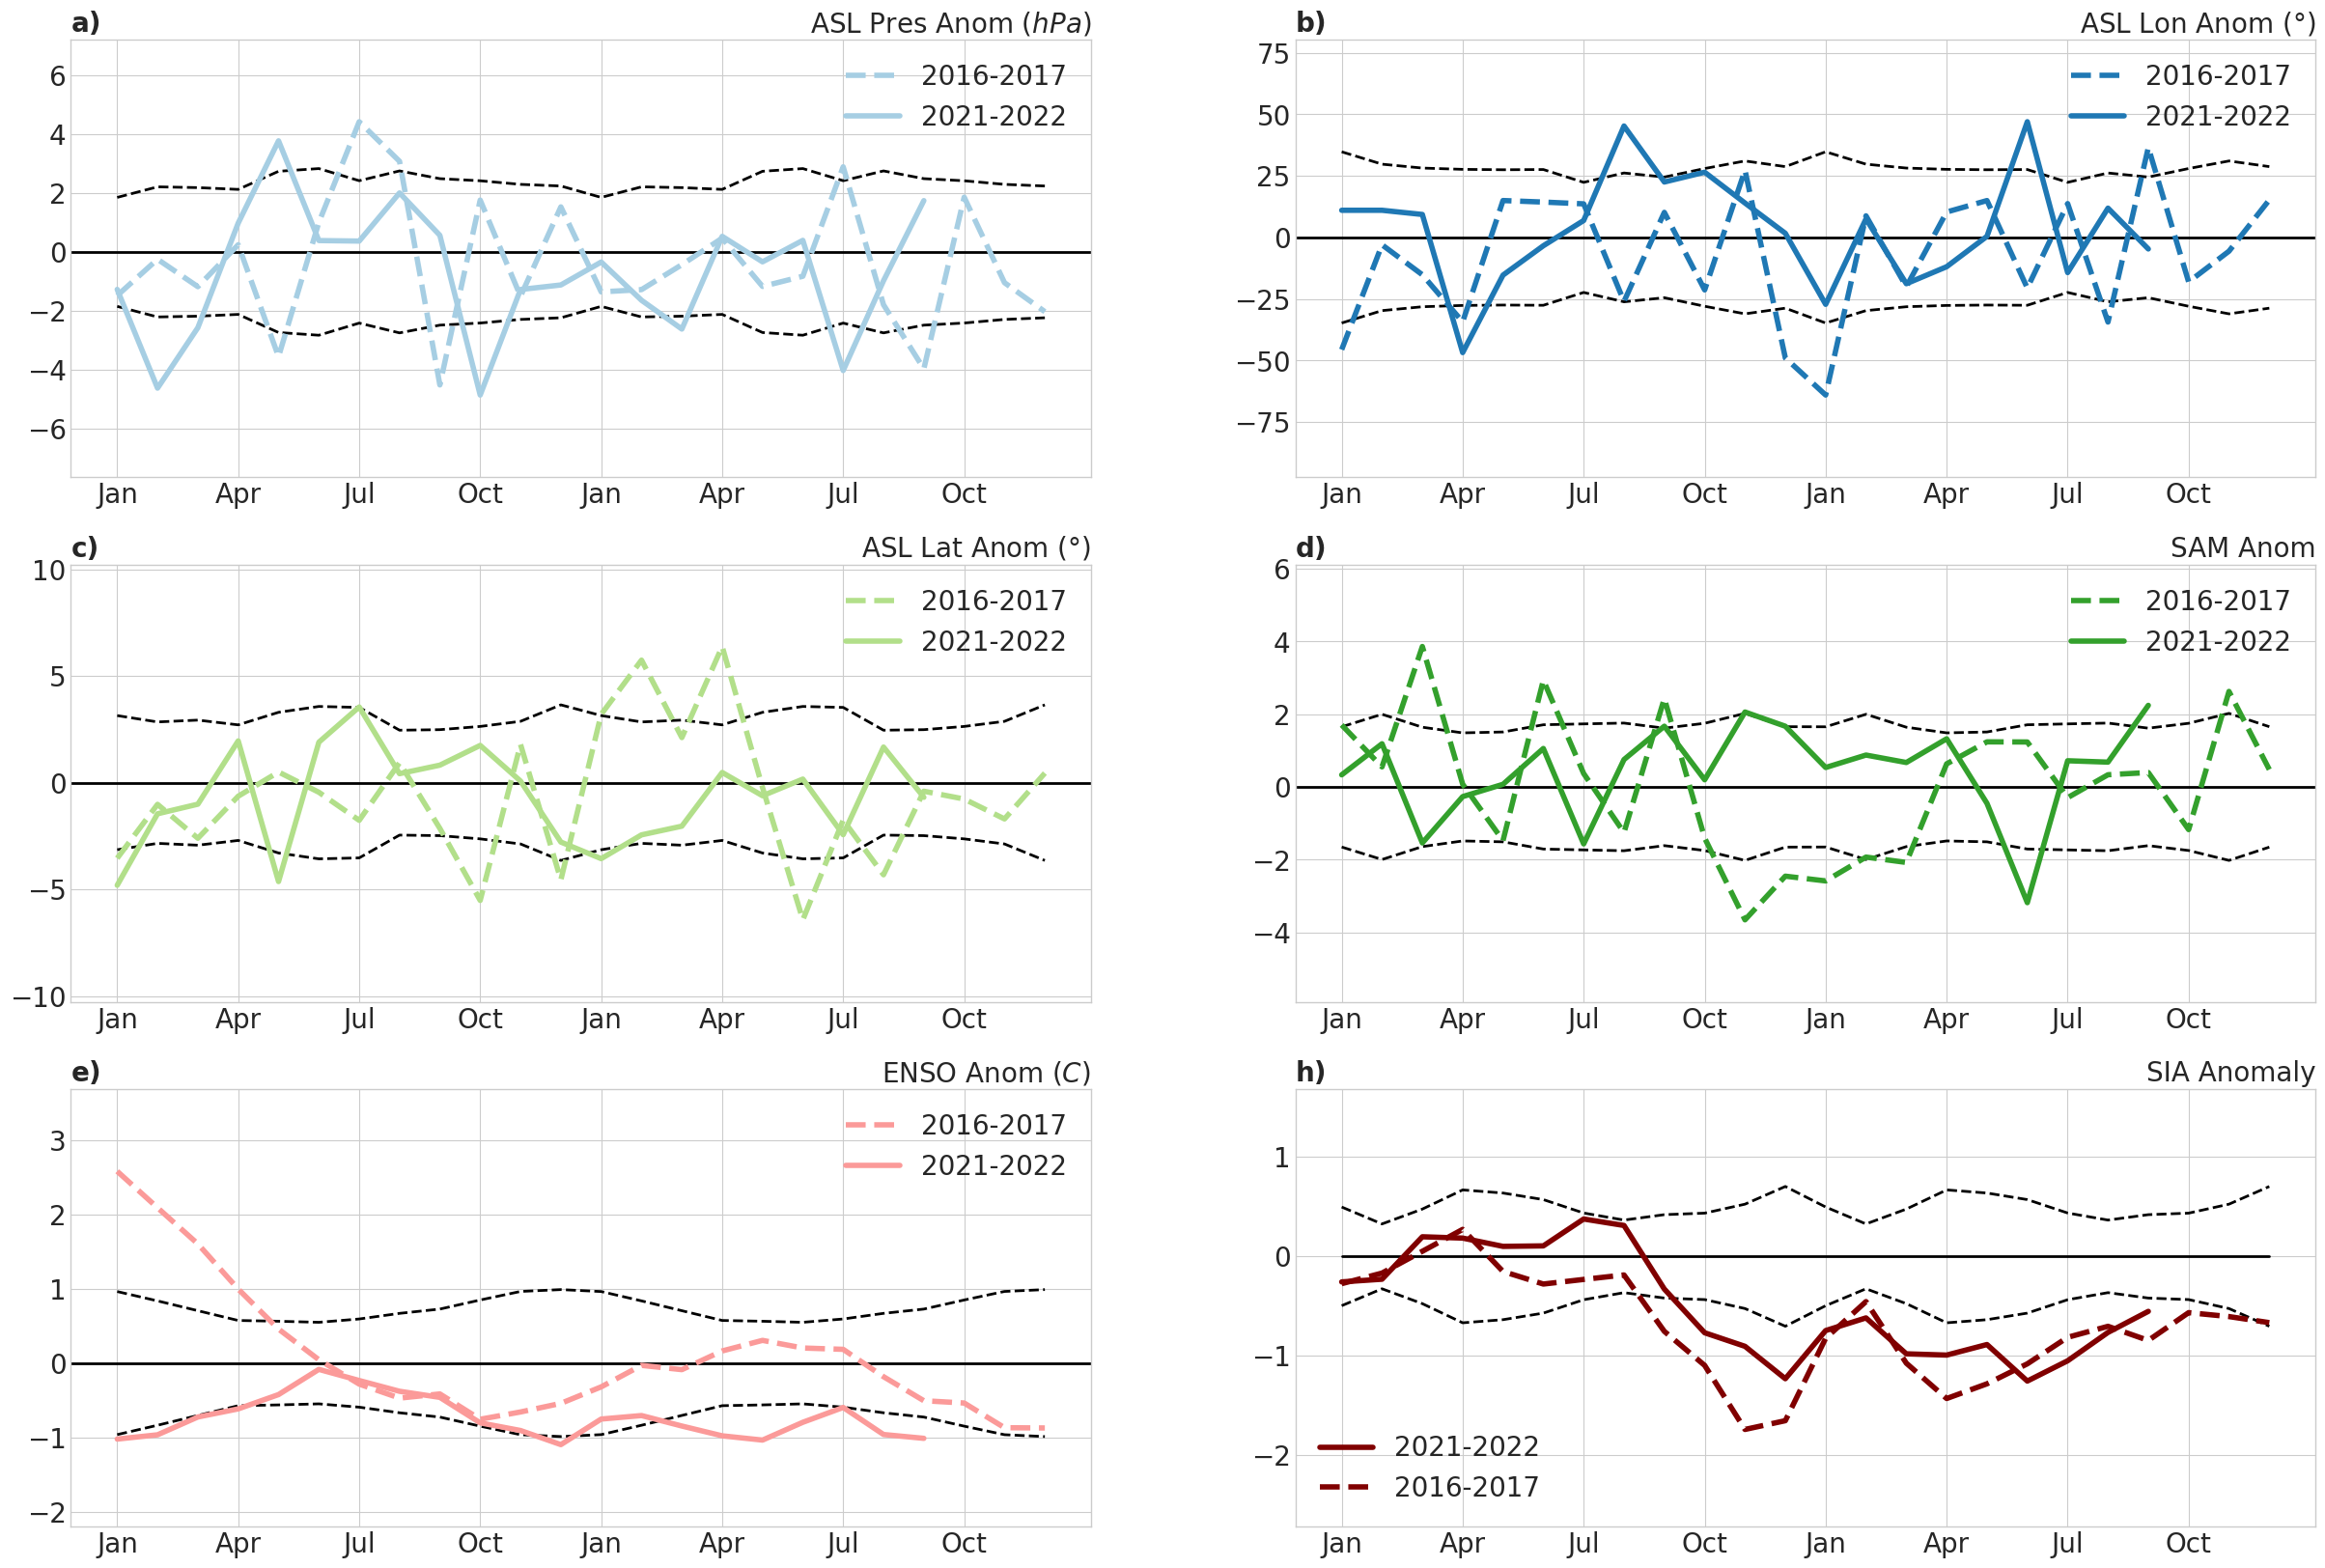

In [55]:
def normalize(s):
    return (s - np.mean(s)) / np.std(s)

def prep_indices(asl, sam, nino34):
    # get asl detrended monthly anoms
    asl_monthly = xarray_time_to_monthly(asl)
    asl_detrend = detrend_data(asl_monthly, asl_monthly.year, "year")
    asl_std = asl_detrend.std(["year"])
    asl = xarray_monthly_to_time(asl_detrend)
    
    # get sam detrended monthly anoms
    sam_detrend = detrend_data(sam_marshall, sam_marshall.year, "year")
    sam_std = sam_detrend.std(["year"])
    sam = xarray_monthly_to_time(sam_detrend)
    
    # get nino34 detrended monthly anoms
    nino34_detrend = detrend_data(nino34, nino34.year, "year")
    nino34_std = nino34_detrend.std(["year"])
    nino34 = xarray_monthly_to_time(nino34_detrend)
    
    return [
        (r"ASL Pres Anom ($hPa$)", asl_std.sel(index="RelCenPres"), asl.sel(index="RelCenPres")),
        (r"ASL Lon Anom ($\degree$)", asl_std.sel(index="lon"), asl.sel(index="lon")),
        (r"ASL Lat Anom ($\degree$)", asl_std.sel(index="lat"), asl.sel(index="lat")),
        ("SAM Anom", sam_std, sam),
        (r"ENSO Anom ($C$)", nino34_std, nino34),
    ]


def compare_indices(df_tot):
    # Create time series
    tfut = np.arange("2021-01", "2022-10", dtype="datetime64[M]")
    tpast = np.arange("2016-01", "2018-01", dtype="datetime64[M]")
    tseries = np.arange(len(tpast))
    tseries_fut = np.arange(len(tfut))

    fig, axs = plt.subplots(3, 2, figsize=(30, 20))
    axs = axs.flatten()
    for i, ax in enumerate(axs): 
        if i == len(df_tot): continue
        title, std, df = df_tot[i]
        
        df_past = df.sel(time=tpast)
        df_fut = df.sel(time=tfut)
        df_std = 2*list(std.values)
        df_std_neg = 2*list(-std.values)
        
        # Plot mean and 1 sigma
        ax.axhline(0, c="black", linewidth=2)
        ax.plot(tseries, df_std, c="black", linewidth=2, linestyle="dashed")
        ax.plot(tseries, df_std_neg, c="black", linewidth=2, linestyle="dashed")
        
        # Plot Extreme Events
        ax.plot(tseries, df_past, c=colors[i], linestyle="dashed", label="2016-2017")
        ax.plot(tseries_fut, df_fut, c=colors[i], label="2021-2022")
        
        # Set plot info
        ax.set_title(title, loc="right")
        ax.set_title(figlabels[i], loc="left", fontweight="bold")
        ax.set_xticks(np.arange(0, len(tpast), 3))
        months = 2*["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        ax.set_xticklabels(months[::3])
        ax.set_ymargin(0.3)
        ax.grid(True)
        ax.legend()

    # Plot sea ice anoms
    mu_sice = np.zeros(len(tpast))
    std_sice = 2*list(siaNSIDC_std.sel(region="total").values)
    
    axs[-1].plot(tseries, mu_sice, color="black", linewidth=2) 
    axs[-1].plot(tseries, mu_sice + std_sice, color="black", linewidth=2, linestyle="dashed") 
    axs[-1].plot(tseries, mu_sice - std_sice, color="black", linewidth=2, linestyle="dashed") 
    axs[-1].plot(tseries_fut, siaNSIDC_anoms.sel(time=tfut), color="maroon", label="2021-2022")
    axs[-1].plot(tseries, siaNSIDC_anoms.sel(time=tpast), color="maroon", linestyle="dashed", label="2016-2017")
    axs[-1].set_ymargin(0.4)
    axs[-1].set_title("SIA Anomaly", loc="right")
    axs[-1].set_title(figlabels[-1], loc="left", fontweight="bold")
    axs[-1].set_xticks(np.arange(0, len(tpast), 3))
    months = 2*["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    axs[-1].set_xticklabels(months[::3])
    axs[-1].legend()

    plt.savefig("/glade/work/zespinosa/Projects/antarctic-2022_record-low_nudge-analysis/figures/indices_comparison.png")

def main():
    df_idx = prep_indices(asl, sam_marshall, nino34)
    compare_indices(df_idx)
    
main()